ENV 반복 실험 후 증가 메모리 확인

초기 메모리: 1141.02 MB
메모리 누수 테스트 시작...


100%|██████████| 1000/1000 [01:28<00:00, 11.25it/s]

종료 메모리: 1141.02 MB
증가량: 0.00 MB


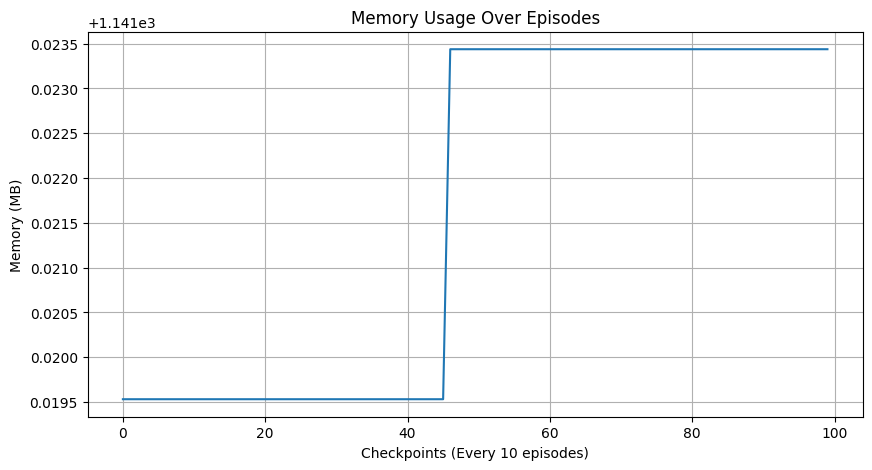

In [4]:
import gymnasium as gym
import horcrux_env
import psutil
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

ENV_NAME = "horcrux_env/plane-v0"

def get_current_memory_usage():
    """현재 프로세스의 메모리 사용량(MB)을 반환합니다."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def check_memory_leak(env, num_episodes=1000, steps_per_episode=50):
    memory_usages = []
    
    print(f"초기 메모리: {get_current_memory_usage():.2f} MB")
    print("메모리 누수 테스트 시작...")

    for i in tqdm(range(num_episodes)):
        # 1. 환경 리셋
        obs, info = env.reset()
        
        # 2. 시뮬레이션 스텝 진행
        for _ in range(steps_per_episode):
            action = env.action_space.sample() # 랜덤 액션
            obs, reward, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                break
        
        # 3. 주기적으로 가비지 컬렉션 강제 수행 (Python의 게으른 해제 배제 목적)
        # 실제 누수인지, 단순히 GC가 아직 안 돈 건지 구분하기 위함
        if i % 10 == 0:
            gc.collect() 
            current_mem = get_current_memory_usage()
            memory_usages.append(current_mem)

    # 결과 시각화
    print(f"종료 메모리: {memory_usages[-1]:.2f} MB")
    print(f"증가량: {memory_usages[-1] - memory_usages[0]:.2f} MB")

    plt.figure(figsize=(10, 5))
    plt.plot(memory_usages)
    plt.title("Memory Usage Over Episodes")
    plt.xlabel("Checkpoints (Every 10 episodes)")
    plt.ylabel("Memory (MB)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = gym.make(ENV_NAME) 

    try:
        check_memory_leak(env, num_episodes=1000, steps_per_episode=100)
    finally:
        env.close() # 중요: 테스트 종료 후 리소스 해제